# Text Classification Procedure and Results

The following notebook details the machine learning procedure and results for training a classification model on the BCStats WES Comment data. The purpose of this notebook is to illustrate the details of the code in a digestable format.

This analysis notebook best accompanies the [MDS Final Report]() which introduces the problem and more formally describes the methodology and results. To learn how to implement the data on future WES comments see the [WES Classification USAGE]() notebook.

In [1]:
# Change working directory to be project root
import os
#os.chdir("..")
os.getcwd()

'/Users/aaronquinton/Documents/UBC-MDS/Capstone/BCstats/DSCI_591_capstone-BCStats'

In [1166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import time

# Custom functions for preprocessing, data preparation, and evaluation
from src.data.preprocessing_text import (
    clean_text, clean_numbers, replace_typical_misspell, remove_stopwords,
    preprocess_for_embed, preprocess_for_bow
)

from src.features.word_vectors import (
    build_vocab, check_coverage, get_average_embeddings
)

from src.models.eval import theme_results, investigate_results

# Functions for preprocessing, data preparation, and evaluation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Training Word embeddings and pre-trained embeddings
import gensim
from gensim.models import Word2Vec, KeyedVectors

# Keras Deep learning functions for LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras.layers import GRU, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# Classification alogrithms
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


## <span style = "color:Darkblue"> Read in Data and Embeddings </span>

In [316]:
# Input Filepaths
# Data Files
fname_rawdata2018 = "data/interim/train_2018-qualitative-data.csv"
fname_quant = "data/processed/tidy_quant_questions.csv"
fname_legend = "references/data-dictionaries/survey_mc_legend.csv"

# Pre-trained Embeddings
fname_fasttext_crawl = "./references/pretrained_embeddings.nosync/fasttext/" \
                       "crawl-300d-2M.vec"
fname_fasttext_wiki = "./references/pretrained_embeddings.nosync/fasttext/" \
                      "wiki-news-300d-1M.vec"
fname_w2v_googlenews = "./references/pretrained_embeddings.nosync/" \
                       "GoogleNews-vectors-negative300.bin"
fname_glove_twitter = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.twitter.27B.200d.w2v.txt"
fname_glove_wiki = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.6B.300d.w2v.txt"
fname_glove_crawl = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.840B.300d.w2v.txt"

In [275]:
# Read in raw data
df = pd.read_csv(fname_rawdata2018)

In [5]:
t_start = time.time()

# Read in pre-trained embeddings
w2v_google_news = KeyedVectors.load_word2vec_format(fname_w2v_googlenews,
                                                    binary=True)
fasttext_crawl = KeyedVectors.load_word2vec_format(fname_fasttext_crawl,
                                                   unicode_errors='ignore')
fasttext_wiki = KeyedVectors.load_word2vec_format(fname_fasttext_wiki,
                                                  unicode_errors='ignore')
glove_twitter = KeyedVectors.load_word2vec_format(fname_glove_twitter,
                                                  unicode_errors='ignore')
glove_wiki = KeyedVectors.load_word2vec_format(fname_glove_wiki,
                                               unicode_errors='ignore')
glove_crawl = KeyedVectors.load_word2vec_format(fname_glove_crawl,
                                                unicode_errors='ignore')

t_end = time.time()
print("Elapsed time to load embeddings: %.1f s" % (t_end - t_start))

Elapsed time to load embeddings: 2958.4 s


## <span style = "color:Darkblue"> Preprocessing and Data Preperation</span>

### Preparing Comment data

In [276]:
df_userid = df[['_telkey', '2018 Comment']]
df_userid = df_userid.rename(columns = {'_telkey':'USERID'})

df = df[['2018 Comment']].join(df.loc[:,'CPD':'OTH'])
df = df.rename(columns = {'2018 Comment' : 'comment'})

Y = np.array(df.loc[:,"CPD":"OTH"])

themes = df.loc[:,'CPD':'OTH'].columns.tolist()

# Split the data
df_X_train, df_X_valid, Y_train, Y_valid = train_test_split(
        df.comment, Y, test_size=0.25, random_state=2019)

In [339]:
print(df_X_train.shape)
print(Y_train.shape)

(9958,)
(9958, 12)


### Prepare Quantitative Data

In [298]:
df_quant = pd.read_csv(fname_quant).query("survey_year == 2018")
df_legend = pd.read_csv(fname_legend)

In [340]:
df_quant_train = df_userid.loc[df_X_train.index] \
                          .merge(df_quant, how='left', on='USERID')

df_quant_valid = df_userid.loc[df_X_valid.index] \
                          .merge(df_quant, how='left', on='USERID')

In [1051]:
X_train_quant = np.array(df_quant_train.iloc[:,3:20])
X_valid_quant = np.array(df_quant_valid.iloc[:,3:20])

In [1055]:
# Fill missing values with the mean response for that column
for i in range(X_train_quant.shape[1]):
    mean_replace = np.nanmean(X_train_quant, axis = 0)[i]
    X_train_quant[:,i][np.isnan(X_train_quant[:,i])] = mean_replace
    X_valid_quant[:,i][np.isnan(X_valid_quant[:,i])] = mean_replace


In [1058]:
print(X_train_quant.shape)
print(X_valid_quant.shape)

(9958, 17)
(3320, 17)


### Train Word Vectors

In [241]:
comments = preprocess_for_embed(df.comment, 'w2v_base_model')

w2v_base_model = Word2Vec(comments, 
                     size=300, 
                     window=5, 
                     min_count=1,
                     sg=1, 
                     negative=4)        

In [242]:
# Dictionary of pretrained embeddings
embeddings = {'w2v_base_model': w2v_base_model,
              'w2v_google_news': w2v_google_news, 
              'fasttext_crawl': fasttext_crawl,
              'fasttext_wiki': fasttext_wiki,
              'glove_twitter': glove_twitter,
              'glove_wiki': glove_wiki,
              'glove_crawl': glove_crawl}

### Word Embedding Vocab Coverage

In [243]:
# Check coverage of vocab words in embedding
oov = {}
vocab_coverage = []
text_coverage = []

for embedding in embeddings.keys():
    
    comments = preprocess_for_embed(df.comment, embedding)
    vocab = build_vocab(comments)
        
    a, b, oov[embedding] = check_coverage(vocab, embeddings[embedding])
    
    vocab_coverage.append(a)
    text_coverage.append(b)

pd.DataFrame({'embedding': list(embeddings.keys()),
              'vocab_coverage': vocab_coverage, 
              'text_coverage': text_coverage})

100%|██████████| 17500/17500 [00:06<00:00, 2735.08it/s]


,embedding,vocab_coverage,text_coverage
0,w2v_base_model,1.000000,1.000000
1,w2v_google_news,0.939870,0.996661
2,fasttext_crawl,0.953943,0.997412
3,fasttext_wiki,0.938514,0.996345
4,glove_twitter,0.887954,0.990666
5,glove_wiki,0.913479,0.994892
6,glove_crawl,0.953543,0.997421


In [244]:
# Take a look at the out of vocab words for each embedding
for i in oov.keys():
    print(i)
    print(oov[i][:5])

w2v_base_model
[]
w2v_google_news
[('CYMH', 54), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32), ('BCWS', 23)]
fasttext_crawl
[('CYMH', 54), ('BCTS', 37), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32)]
fasttext_wiki
[('MCFD', 128), ('CYMH', 54), ('BCTS', 37), ('FLNRORD', 35), ('GCPE', 33)]
glove_twitter
[('2', 402), ('1', 302), ('3', 236), ('4', 171), ('5', 151)]
glove_wiki
[('####', 181), ('mcfd', 131), ('cymh', 54), ('#####', 49), ('bcts', 37)]
glove_crawl
[('CYMH', 54), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32), ('STIIP', 20)]


## <span style = "color:Darkblue"> Feature Engineering </span>

### Bag of Words


In [245]:
# Use Count Vectorizer to build bag of word arrays to train on
vectorizer = CountVectorizer(stop_words= 'english',
                             ngram_range=(1,5), 
                             min_df=2)   

X_train_bow = vectorizer.fit_transform(preprocess_for_bow(df_X_train))
X_valid_bow = vectorizer.transform(preprocess_for_bow(df_X_valid))

In [246]:
print(X_train_bow.shape)
print(X_valid_bow.shape)

(9958, 31422)
(3320, 31422)


### Get Average Word Vectors per Comment

In [247]:
X_train_avg_wv = {}
X_valid_avg_wv = {}

for embedding in embeddings.keys():
    
    # Adjust features based on twitter embeddings 
    if embedding == 'glove_twitter':
        n_features = 200
    else:
        n_features = 300
    
    # Preprocess comment data
    comments_train = preprocess_for_embed(df_X_train, embedding)
    comments_valid = preprocess_for_embed(df_X_valid, embedding)
    
    # Get average embeddings for each comment
    # train
    X_train_avg_wv[embedding] = np.array(
        [get_average_embeddings(comment, embeddings[embedding], n_features)
         for comment in comments_train])
    
    # valid
    X_valid_avg_wv[embedding] = np.array(
        [get_average_embeddings(comment, embeddings[embedding], n_features)
         for comment in comments_valid])

In [248]:
print(X_valid_avg_wv['w2v_base_model'].shape)
print(X_valid_avg_wv['glove_twitter'].shape)

(3320, 300)
(3320, 200)


## <span style = "color:Darkblue"> Classification Models </span>
### Baseline Classifier - BOW | Linear SVC 

#### Optimize Hyper Parameters for BOW | Linear SVC

In [829]:
# C = (5.0**np.arange(-1,4)/10).tolist()
# C.append(1)

# tol = (5.0**np.arange(-3,2)/100).tolist()
# tol.append(0.0001)

# print('C:', C)
# print('tol:', tol)

C: [0.02, 0.1, 0.5, 2.5, 12.5, 1]
tol: [8e-05, 0.0004, 0.002, 0.01, 0.05, 0.0001]


In [830]:
# t_start = time.time()
# print("Grid Search for BOW | Linear SVC")

# parameters = [
#     {
#         'classifier':[LinearSVC(max_iter=2000)],
#         'classifier__tol': tol,
#         'classifier__C': C,    
#     }
# ]

# clf1 = GridSearchCV(BinaryRelevance(), parameters, scoring = 'accuracy', cv = 2)
# clf1.fit(X_train_bow, Y_train)

# t_end_train = time.time()

# print(clf1.best_params_, clf1.best_score_)
# # Calculate and print elapsed time
# t_end = time.time()
# print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
#       "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))

Grid Search for BOW | Linear SVC
{'classifier': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.05,
     verbose=0), 'classifier__C': 0.5, 'classifier__tol': 0.05} 0.4243824061056437
Elapsed Training time: 5454.6 s 
Elapsed Predict time: 0.1 s


#### Final BOW | Linear SVC Model

In [837]:
t_start = time.time()
print("Training Bag of words Model with Linear SVC")

model_bow = BinaryRelevance(
    classifier = LinearSVC(C = 0.5, tol = 0.2)
)

model_bow.fit(X_train_bow, Y_train)
t_end_train = time.time()

Y_pred_bow = model_bow.predict(X_valid_bow).toarray()

# Calculate and print elapsed time
t_end = time.time()
print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
      "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))

Training Bag of words Model with Linear SVC
Elapsed Training time: 71.4 s 
Elapsed Predict time: 13.1 s


In [1091]:
results_bow = pd.DataFrame({'Model': 'BOW | LinearSVC',
                            'train_time': [71.4],
                            'predict_time': [13.1],
                            'overall_accuracy': [metrics.accuracy_score(Y_valid, 
                                                                       Y_pred_bow)]})

In [838]:
theme_results(Y_valid, Y_pred_bow)

Overall Accuracy: 0.4512 
Hamming Loss: 0.0721 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.127410,0.112048,0.073193,0.054217,0.926807,0.741935,0.652482
1,CB,0.184639,0.174096,0.043072,0.141566,0.956928,0.906574,0.854812
2,EWC,0.084337,0.056325,0.067771,0.016566,0.932229,0.647059,0.432143
3,Exec,0.103012,0.089157,0.081325,0.021687,0.918675,0.621622,0.538012
4,FWE,0.062048,0.054217,0.025904,0.036145,0.974096,0.833333,0.728155
5,SP,0.096386,0.082229,0.065964,0.030422,0.934036,0.684982,0.584375
6,RE,0.085542,0.062952,0.075602,0.009940,0.924398,0.578947,0.426056
7,Sup,0.127711,0.111145,0.105723,0.021988,0.894277,0.598916,0.521226
8,SW,0.165964,0.134639,0.115060,0.050904,0.884940,0.689038,0.558984
9,TEPE,0.228614,0.211145,0.071687,0.156928,0.928313,0.871612,0.805007


In [839]:
print("Shape of Y_pred:",Y_pred_bow.shape)
print("Zeros predicted:",Y_pred_bow[Y_pred_bow.sum(axis = 1) == 0,:].shape)

Shape of Y_pred: (3320, 12)
Zeros predicted: (466, 12)


### Average Word Vectors | LogReg SVC

#### Optimize Hyperparameters for Avg WV | LogReg

In [ ]:
# C = (5.0**np.arange(-1,4)/10).tolist()
# C.append(1)

# tol = (5.0**np.arange(-3,2)/100).tolist()
# tol.append(0.0001)

# print('C:', C)
# print('tol:', tol)

In [ ]:
# for embedding in embeddings.keys():
    
#     print("Grid Search on: ", embedding)
#     t_start = time.time()

#     parameters = [
#         {
#             'classifier':[LogisticRegression(solver = 'lbfgs', max_iter=500)],
#             'classifier__tol': tol,
#             'classifier__C': C,
        
#         }
#     ]

#     clf2 = GridSearchCV(BinaryRelevance(), parameters, scoring = 'accuracy', cv = 2)
#     clf2.fit(X_train_avg_wv[embedding], Y_train)

#     t_end_train = time.time()

#     print(clf2.best_params_, clf2.best_score_)
#     # Calculate and print elapsed time
#     t_end = time.time()
#     print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
#       "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))


#### Final Avg WV | LogReg Model

In [845]:
Y_pred_avg_wv = {}
model_avg_wv = {}
train_time = []
predict_time = []
accuarcies = []

for embedding in embeddings.keys():
    t_start = time.time()

    clf = BinaryRelevance(
        classifier = LogisticRegression(solver = 'lbfgs', max_iter=500, C = 7.5,
                                        tol = 0.05)
    )

    clf.fit(X_train_avg_wv[embedding], Y_train)
    t_end_train = time.time()

    Y_pred_avg_wv[embedding] = clf.predict_proba(X_valid_avg_wv[embedding]) \
                                  .toarray()
    model_avg_wv[embedding] = clf
    
    # Calculate elapsed time
    t_end = time.time()
    train_time.append(t_end_train - t_start)
    predict_time.append(t_end - t_end_train)
    
    accuarcies.append(metrics.accuracy_score(Y_valid,
                                             np.round(Y_pred_avg_wv[embedding])))

results_avg_wv = pd.DataFrame({'embedding': list(embeddings.keys()),
                               'train_time': train_time,
                               'predict_time': predict_time,
                               'overall_accuracy': accuarcies})

results_avg_wv

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,6.191823,0.065399,0.360843
1,w2v_google_news,4.602850,0.222380,0.406325
2,fasttext_crawl,5.089044,0.190777,0.421687
3,fasttext_wiki,4.718872,0.276683,0.398795
4,glove_twitter,7.091348,0.339133,0.354217
5,glove_wiki,9.596981,0.359630,0.406024
6,glove_crawl,8.432222,0.280792,0.409337


### LSTM Model

In [840]:
# Build Embedding Matrices and prepare data for deep 
# learning Models
max_words = 12000
maxlen = 700

# dictionaries for each embedding
embedding_matrix = {}
tokenizer = {}
X_train_lstm = {}
X_valid_lstm = {}

for embedding in embeddings.keys():

    # Preprocess text data based on embedding
    X_train = np.array(preprocess_for_embed(df_X_train,
                                            embedding,
                                            split = False))
    
    X_valid = np.array(preprocess_for_embed(df_X_valid,
                                            embedding,
                                            split = False))
    
    # Tokenize and pad numbers for LSTM Model
    tokenizer[embedding] = Tokenizer(num_words=max_words)
    tokenizer[embedding].fit_on_texts(X_train)
    
    tokenized_train = tokenizer[embedding].texts_to_sequences(X_train)
    tokenized_test = tokenizer[embedding].texts_to_sequences(X_valid)

    X_train_lstm[embedding] = pad_sequences(tokenized_train, maxlen=maxlen)
    X_valid_lstm[embedding] = pad_sequences(tokenized_test, maxlen=maxlen)
    
    
    # Build Embedding Matrices
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300

    word_index = tokenizer[embedding].word_index
    
    num_words = min(max_words, len(word_index) + 1)
    embedding_matrix[embedding] = np.zeros((num_words, embed_size),
                                           dtype='float32')

    for word, i in word_index.items():

        if i >= max_words:
            continue

        try:
            embedding_vector = embeddings[embedding][word]

            if embedding_vector is not None:
                embedding_matrix[embedding][i] = embedding_vector
        except:
            continue

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [1179]:
# Build LSTM Model and train and validate
Y_pred_lstm = {}
model_lstm = {}
train_time = []
predict_time = []
accuarcies = []

for embedding in embeddings.keys():
    t_start = time.time()
    print("Training LSTM on the ", embedding)
    
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300
    
    # Deep Learning Architecture
    inp = Input(shape=(maxlen, ))
    
    x = Embedding(max_words, embed_size, 
                  weights=[embedding_matrix[embedding]], 
                  trainable=False)(inp)

    x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1,
                          recurrent_dropout=0.1))(x)

    x = Conv1D(64, kernel_size=3, padding="valid", 
               kernel_initializer="glorot_uniform")(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)

    x = concatenate([avg_pool, max_pool])

    preds = Dense(12, activation="sigmoid")(x)

    model = Model(inp, preds)

    model.compile(loss='binary_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])

    # Train and Predict Model
    batch_size = 128
    epochs = 16
    model.fit(X_train_lstm[embedding],
              Y_train,
              batch_size=batch_size,
              epochs=epochs, 
              validation_data = (X_valid_lstm[embedding],
                                 Y_valid))
    t_end_train = time.time()
    
    Y_pred_lstm[embedding] = model.predict(X_valid_lstm[embedding])
    model_lstm[embedding] = model

    # Calculate and report results
    t_end = time.time()
    train_time.append(t_end_train - t_start)
    predict_time.append(t_end - t_end_train)
    
    accuarcies.append(metrics.accuracy_score(Y_valid,
                                             np.round(Y_pred_lstm[embedding])))

Training LSTM on the  w2v_base_model
Train on 9958 samples, validate on 3320 samples
Epoch 1/16
9958/9958 [==============================] - 366s 37ms/step - loss: 0.3358 - acc: 0.8864 - val_loss: 0.2613 - val_acc: 0.9042
Epoch 2/16
9958/9958 [==============================] - 344s 35ms/step - loss: 0.2441 - acc: 0.9103 - val_loss: 0.2177 - val_acc: 0.9189
Epoch 3/16
9958/9958 [==============================] - 345s 35ms/step - loss: 0.2159 - acc: 0.9196 - val_loss: 0.2066 - val_acc: 0.9223
Epoch 4/16
9958/9958 [==============================] - 338s 34ms/step - loss: 0.2029 - acc: 0.9239 - val_loss: 0.1973 - val_acc: 0.9254
Epoch 5/16
9958/9958 [==============================] - 331s 33ms/step - loss: 0.1956 - acc: 0.9262 - val_loss: 0.1930 - val_acc: 0.9269
Epoch 6/16
9958/9958 [==============================] - 328s 33ms/step - loss: 0.1880 - acc: 0.9295 - val_loss: 0.1898 - val_acc: 0.9280
Epoch 7/16
9958/9958 [==============================] - 344s 35ms/step - loss: 0.1827 - acc: 

9958/9958 [==============================] - 295s 30ms/step - loss: 0.1507 - acc: 0.9423 - val_loss: 0.1671 - val_acc: 0.9364
Epoch 11/16
9958/9958 [==============================] - 295s 30ms/step - loss: 0.1463 - acc: 0.9439 - val_loss: 0.1675 - val_acc: 0.9367
Epoch 12/16
9958/9958 [==============================] - 294s 30ms/step - loss: 0.1411 - acc: 0.9458 - val_loss: 0.1644 - val_acc: 0.9376
Epoch 13/16
9958/9958 [==============================] - 295s 30ms/step - loss: 0.1371 - acc: 0.9475 - val_loss: 0.1653 - val_acc: 0.9373
Epoch 14/16
9958/9958 [==============================] - 294s 30ms/step - loss: 0.1320 - acc: 0.9491 - val_loss: 0.1641 - val_acc: 0.9376
Epoch 15/16
9958/9958 [==============================] - 296s 30ms/step - loss: 0.1284 - acc: 0.9510 - val_loss: 0.1637 - val_acc: 0.9372
Epoch 16/16
9958/9958 [==============================] - 294s 30ms/step - loss: 0.1248 - acc: 0.9522 - val_loss: 0.1677 - val_acc: 0.9372
Training LSTM on the  glove_twitter
Train on 9

In [1180]:
results_lstm = pd.DataFrame({'embedding': list(embeddings.keys()),
                             'train_time': train_time,
                             'predict_time': predict_time,
                             'overall_accuracy': accuarcies})

results_lstm

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,5403.565991,51.442252,0.475000
1,w2v_google_news,4783.540461,44.722496,0.498795
2,fasttext_crawl,4740.266720,44.296958,0.510542
3,fasttext_wiki,5182.704977,45.970474,0.506928
4,glove_twitter,3965.183014,35.402969,0.489157
5,glove_wiki,4786.450105,46.403053,0.495181
6,glove_crawl,4865.703469,52.608429,0.515361


In [843]:
theme_results(Y_valid, np.round(Y_pred_lstm['fasttext_crawl']))

Overall Accuracy: 0.5075 
Hamming Loss: 0.0631 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.127410,0.124699,0.064157,0.063253,0.935843,0.753623,0.737589
1,CB,0.184639,0.178614,0.034940,0.149699,0.965060,0.919056,0.889070
2,EWC,0.084337,0.062349,0.058735,0.025602,0.941265,0.705314,0.521429
3,Exec,0.103012,0.105120,0.076205,0.026807,0.923795,0.627507,0.640351
4,FWE,0.062048,0.047289,0.025602,0.036446,0.974398,0.885350,0.674757
5,SP,0.096386,0.088253,0.060542,0.035843,0.939458,0.703072,0.643750
6,RE,0.085542,0.077108,0.072892,0.012651,0.927108,0.582031,0.524648
7,Sup,0.127711,0.109940,0.094880,0.032831,0.905120,0.649315,0.558962
8,SW,0.165964,0.136145,0.093675,0.072289,0.906325,0.765487,0.627949
9,TEPE,0.228614,0.214759,0.056024,0.172590,0.943976,0.901823,0.847167


### Model Summary

#### BOW

In [1092]:
results_bow

,Model,train_time,predict_time,overall_accuracy
0,BOW | LinearSVC,71.4,13.1,0.451205


#### Average Word Vectors

In [1084]:
results_avg_wv

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,6.191823,0.065399,0.360843
1,w2v_google_news,4.602850,0.222380,0.406325
2,fasttext_crawl,5.089044,0.190777,0.421687
3,fasttext_wiki,4.718872,0.276683,0.398795
4,glove_twitter,7.091348,0.339133,0.354217
5,glove_wiki,9.596981,0.359630,0.406024
6,glove_crawl,8.432222,0.280792,0.409337


#### LSTM

In [1082]:
results_lstm

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,3879.478145,50.835208,0.463253
1,w2v_google_news,3545.128112,50.347810,0.502108
2,fasttext_crawl,3841.778025,57.008378,0.507530
3,fasttext_wiki,3767.888280,53.533103,0.490060
4,glove_twitter,2847.951580,40.823633,0.488855
5,glove_wiki,3199.954429,46.572131,0.498795
6,glove_crawl,3316.253327,51.455602,0.507530


## Ensemble Model Predictions

In [1181]:
Y_pred_stack = (Y_pred_lstm['fasttext_crawl'] +
                Y_pred_lstm['glove_crawl'] +
                Y_pred_lstm['glove_wiki'] +
                Y_pred_lstm['w2v_google_news'])/4

In [1182]:
theme_results(Y_valid, np.round(Y_pred_stack))

Overall Accuracy: 0.5386 
Hamming Loss: 0.0588 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.127410,0.113855,0.060542,0.066867,0.939458,0.793651,0.709220
1,CB,0.184639,0.178012,0.034940,0.149699,0.965060,0.920474,0.887439
2,EWC,0.084337,0.044880,0.060542,0.023795,0.939458,0.765101,0.407143
3,Exec,0.103012,0.098795,0.069880,0.033133,0.930120,0.667683,0.640351
4,FWE,0.062048,0.053916,0.020181,0.041867,0.979819,0.888268,0.771845
5,SP,0.096386,0.087048,0.059940,0.036446,0.940060,0.709343,0.640625
6,RE,0.085542,0.065964,0.062952,0.022590,0.937048,0.671233,0.517606
7,Sup,0.127711,0.105422,0.083735,0.043976,0.916265,0.708571,0.584906
8,SW,0.165964,0.145181,0.090060,0.075904,0.909940,0.761411,0.666062
9,TEPE,0.228614,0.223494,0.050301,0.178313,0.949699,0.898922,0.878788


### Increase the Precision! 

In [1187]:
accuracy = []
prob_adj = []
non_zero_percent = []

for i in np.arange(-0.49,0.5,0.01):
    
    prob_adj.append(min((0.5 + i),1))
    predictions = np.round(Y_pred_stack - i)
    
    size = predictions.shape[0]
    zero_size = (predictions[predictions.sum(axis = 1) == 0,:].shape[0])
    
    non_zero_pred = predictions[predictions.sum(axis = 1) != 0,:]
    non_zero_valid = Y_valid[predictions.sum(axis = 1) != 0,:]
    
    accuracy.append(metrics.accuracy_score(non_zero_valid, non_zero_pred))
    non_zero_percent.append(round(1 - zero_size/size, 4))

results_tradeoff = pd.DataFrame({'prob_adj': prob_adj,
                                 'accuracy':accuracy,
                                 'non_zero_percent':non_zero_percent})


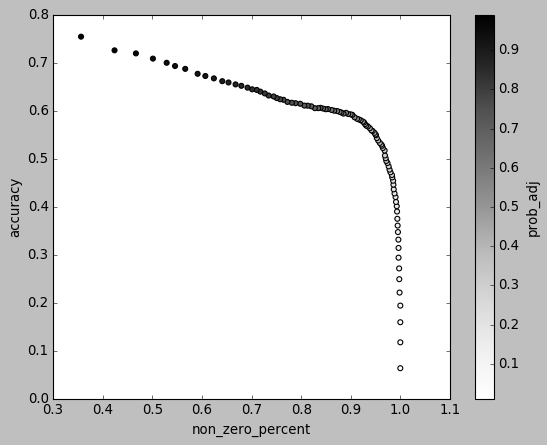

In [1188]:
p = results_tradeoff.plot.scatter(x = 'non_zero_percent',
                              y = 'accuracy',
                              c = 'prob_adj')

plt.show()

In [1193]:
predictions = np.round(Y_pred_stack)

a = theme_results(Y_valid, predictions)
size = predictions.shape[0]
zero_size = (predictions[predictions.sum(axis = 1) == 0,:].shape[0])
print("Total comments:", size, 
      "\nTotal Predictions:", size - zero_size, 
      "\nPercent Pred non-zero:", round(1 - zero_size/size, 4))
a

Overall Accuracy: 0.5386 
Hamming Loss: 0.0588 
Hamming Loss (pred. zeros): 0.1191
Total comments: 3320 
Total Predictions: 3042 
Percent Pred non-zero: 0.9163


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.127410,0.113855,0.060542,0.066867,0.939458,0.793651,0.709220
1,CB,0.184639,0.178012,0.034940,0.149699,0.965060,0.920474,0.887439
2,EWC,0.084337,0.044880,0.060542,0.023795,0.939458,0.765101,0.407143
3,Exec,0.103012,0.098795,0.069880,0.033133,0.930120,0.667683,0.640351
4,FWE,0.062048,0.053916,0.020181,0.041867,0.979819,0.888268,0.771845
5,SP,0.096386,0.087048,0.059940,0.036446,0.940060,0.709343,0.640625
6,RE,0.085542,0.065964,0.062952,0.022590,0.937048,0.671233,0.517606
7,Sup,0.127711,0.105422,0.083735,0.043976,0.916265,0.708571,0.584906
8,SW,0.165964,0.145181,0.090060,0.075904,0.909940,0.761411,0.666062
9,TEPE,0.228614,0.223494,0.050301,0.178313,0.949699,0.898922,0.878788


In [1194]:
non_zero_pred = predictions[predictions.sum(axis = 1) != 0,:]
non_zero_valid = Y_valid[predictions.sum(axis = 1) != 0,:]

theme_results(non_zero_valid, non_zero_pred)

Overall Accuracy: 0.5825 
Hamming Loss: 0.0557 
Hamming Loss (pred. zeros): 0.1215


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.128534,0.124260,0.055556,0.072978,0.944444,0.793651,0.767263
1,CB,0.197239,0.194280,0.033859,0.163379,0.966141,0.920474,0.906667
2,EWC,0.081854,0.048981,0.055884,0.025970,0.944116,0.765101,0.457831
3,Exec,0.103879,0.107824,0.067719,0.036160,0.932281,0.667683,0.693038
4,FWE,0.065746,0.058843,0.020053,0.045694,0.979947,0.888268,0.795000
5,SP,0.099934,0.095003,0.060158,0.039776,0.939842,0.709343,0.674342
6,RE,0.083169,0.071992,0.058514,0.024655,0.941486,0.671233,0.581028
7,Sup,0.123274,0.115056,0.075279,0.047995,0.924721,0.708571,0.661333
8,SW,0.170283,0.158448,0.087442,0.082840,0.912558,0.761411,0.708494
9,TEPE,0.241289,0.243918,0.046680,0.194609,0.953320,0.898922,0.908719
